In [1]:
import requests
import pandas as pd
import io
import collections
from itertools import combinations
import networkx as nx
pd.options.display.max_colwidth = 100
import seaborn as sns
from matplotlib import pyplot as plt
import hashlib

# Introduction
HAL is a platform centralizing data about reserach in France: Researchers are supposed to add in it all their publications, and there is also information about institutions, affiliations of researchers, etc. 

HAL has a website on which you can search manually using a user interface https://hal.archives-ouvertes.fr , but also propose an API allowing to do requests programmatically.

The documentation of this API is relatively limited, but in this notebook, I guide you on how to make a request to the API, and then on how to create networks (co-occurence, etc.) based on the data obtained.
The main page of the official documentation can be found there:
https://api.archives-ouvertes.fr/docs/search

But other pages propose examples of request that can be helpful to understand how to formulate your requests.
* https://wiki.ccsd.cnrs.fr/wikis/hal/index.php/API:Recherche:Hal
* https://api.archives-ouvertes.fr/docs/ref/?resource=structure&schema=fields
* https://www.slideshare.net/OAccsd/usage-des-api-de-hal

# Requests 101
Using python, a single line is enough to make a request to the API. A request is simply an url (that you could also type in a web browser like any normal address), which describe the request we want to make.

The beginnig of the url is always the same and reaches the api of hal: `http://api.archives-ouvertes.fr`.
to make requests on articles, we will add the keyword `/search/` directly after (It would be different to get data about authors or institutions, for instance).

To indicate the topic of our requestion, we will then add `?q=W` where W is the word we are interested in. For instance, to search for my publications, we could write:
`http://api.archives-ouvertes.fr/search/?q=cazabet`


The maximal number of answers we want to receive can be indicated through the option`rows=X`. By default, X=30, and the maximal value is 10 000. Beyond, we have to use a pagination system explained later.

In [2]:
# We make the request and save the result in "response"
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&rows=3")

#We display the result. By default, the answer is in json format. For each corresponding entry (article), there is 
#some basic information.
response.json()

{'response': {'numFound': 52,
  'start': 0,
  'maxScore': 9.318706,
  'numFoundExact': True,
  'docs': [{'docid': '874017',
    'label_s': 'Rémy Cazabet. Détection de communautés dynamiques dans des réseaux temporels. Web. Université Paul Sabatier - Toulouse III, 2013. Français. &#x27E8;NNT : &#x27E9;. &#x27E8;tel-00874017&#x27E9;',
    'uri_s': 'https://theses.hal.science/tel-00874017v1'},
   {'docid': '1500352',
    'label_s': "Rémy Cazabet, Pierre Borgnat, Pablo Jensen. Using Degree Constrained Gravity Null-Models to understand the structure of journeys' networks in Bicycle Sharing Systems. ESANN 2017 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2017, Bruges, Belgium. &#x27E8;hal-01500352&#x27E9;",
    'uri_s': 'https://hal.science/hal-01500352v1'},
   {'docid': '1500356',
    'label_s': 'Jean Creusefond, Rémy Cazabet. Characterising Inter and Intra-Community Interactions in Link Streams Using Temporal Motifs. CompleNet 201

# Requests: fields accessible
To analyze results in depth, results provided as a single text fields are not convenient. It is possible to request specific fields by specifying them as follows:
`fl=champ1,champ2,...,champX`.
To the best of my knowledge, there is no exhaustive list of fields in the documentation. Below, I list a selction of fields that appeared to me as the most interesting ones:
* `title_s`: Title of the article
* `authFullName_s`: Comple name of authors
* `keyword_s`: Keywords of the article (when available)
* `publicationDate_s` or `publicationDateY_s`: Publication date (second: year only)
* `publisher_s`: Publisher of the article
* `docType_s`: Type of publication (conference, Journal article, book chapter, thesis...)
* `structName_s`: Names of the institutions the authors are affiliated to (be careful, there are often several strucutres by authors, linked using another field)
* `structCountry_s`: For each institution, its country
* `structType_s`: for each institution, its type (laboratory, university, university group...)
* `structAddress_s`: For each instituions, its address (useful to get cities for instance)
* `structHasAuthId_fs`: Fields allowing to match authors and their institutions
* `journalTitle_s`: Title of the journal (if it's a journal, else empty)
* `conferenceTitle_s`: Title of the conference (if it's a conference, else empty)
* `popularLevel_s`: 1=pop science publication, 0= not pop science, NaN: status unknown
* `domainAllCode_s`,`level0_domain_s`,`domain_s`,`level1_domain_s`: domains (scientific fields), at different levels of granularity


In [3]:
#For instance, to get titles, keywords, publication dates, institutions
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&rows=2&fl=title_s,keyword_s,publicationDate_s,structName_s")
response.json()

{'response': {'numFound': 52,
  'start': 0,
  'maxScore': 9.318706,
  'numFoundExact': True,
  'docs': [{'title_s': ['Détection de communautés dynamiques dans des réseaux temporels',
     'Detection of dynamic communities in temporal networks'],
    'keyword_s': ['Détection de communautés',
     'Grands graphes',
     'Grands réseaux',
     'Réseaux dynamiques',
     'Communautés dynamiques',
     'Réseaux sociaux web 20'],
    'structName_s': ['National Institute of Informatics'],
    'publicationDate_s': '2013-03-26'},
   {'title_s': ["Using Degree Constrained Gravity Null-Models to understand the structure of journeys' networks in Bicycle Sharing Systems"],
    'structName_s': ['ComplexNetworks',
     "Laboratoire d'Informatique de Paris 6",
     'Université Pierre et Marie Curie - Paris 6',
     'Centre National de la Recherche Scientifique',
     "Laboratoire de Physique de l'ENS Lyon",
     'École normale supérieure de Lyon',
     'Université Claude Bernard Lyon 1',
     'Univers

## Results in .csv
It might be more convenient to get data in  .csv and to display it using the pandas library (note the added `wt=csv` to specify the format. See https://api.archives-ouvertes.fr/docs/search for other possible formats.)

In [4]:
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&wt=csv&rows=6&fl=title_s,publicationDate_s,keyword_s,structName_s")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,title_s,publicationDate_s,keyword_s,structName_s
0,"Détection de communautés dynamiques dans des réseaux temporels,Detection of dynamic communities ...",2013-03-26,"Détection de communautés,Grands graphes,Grands réseaux,Réseaux dynamiques,Communautés dynamiques...",National Institute of Informatics
1,Using Degree Constrained Gravity Null-Models to understand the structure of journeys' networks i...,2017-04,NaN,"ComplexNetworks,Laboratoire d'Informatique de Paris 6,Université Pierre et Marie Curie - Paris 6..."
2,Characterising Inter and Intra-Community Interactions in Link Streams Using Temporal Motifs,2017,NaN,"Equipe AMACC - Laboratoire GREYC - UMR6072,Groupe de Recherche en Informatique\, Image et Instru..."
3,Edge based stochastic block model statistical inference,2021-01-05,"Community,Stochastic block model,Statistical inference","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U..."
4,Optimal Subgroup Discovery in Purely Numerical Data,2020-05-11,"Subgroup Discovery,Pattern Mining,Numerical Data","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U..."
5,Enhancing Space-Aware Community Detection Using Degree Constrained Spatial Null Model,2017-03,NaN,"ComplexNetworks,Laboratoire d'Informatique de Paris 6,Université Pierre et Marie Curie - Paris 6..."


# Advanced search
One can make more complex requests : several words together with `AND`, one word or another with (`OR`), use wildcard for one letter (`?`), or for an undefined number of letters (`*`), etc. 
The request can be on one particular field with `Champ:requête`.

All possibilities are described in the documentation
https://api.archives-ouvertes.fr/docs/search

In [5]:
#For instance, let's look for articles written by an author whose name is cazabet and which contains
#a word starting with commu (commu*) in the title, which covers simultaneously 
# community, communities, communautés, etc.
response = requests.get("http://api.archives-ouvertes.fr/search/?q=title_t:commu* AND authFullName_t:cazabet&wt=csv&fl=title_s,authFullName_s")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,title_s,authFullName_s
0,"Détection de communautés dynamiques dans des réseaux temporels,Detection of dynamic communities ...",Rémy Cazabet
1,"CDLIB: a python library to extract\, compare and evaluate communities from complex networks","Giulio Rossetti,Letizia Milli,Rémy Cazabet"
2,Characterising Inter and Intra-Community Interactions in Link Streams Using Temporal Motifs,"Jean Creusefond,Rémy Cazabet"
3,Challenges in Community Discovery on Temporal Networks,"Rémy Cazabet,Giulio Rossetti"
4,Community Discovery in Dynamic Networks: a Survey,"Giulio Rossetti,Rémy Cazabet"
5,Challenges in Community Discovery on Temporal Networks,"Rémy Cazabet,Giulio Rossetti"
6,Enhancing Space-Aware Community Detection Using Degree Constrained Spatial Null Model,"Rémy Cazabet,Pierre Borgnat,Pablo Jensen"
7,Evaluating Community Detection Algorithms for Progressively Evolving Graphs,"Rémy Cazabet,Souâad Boudebza,Giulio Rossetti"
8,Tracking bitcoin users activity using community detection on a network of weak signals,"Rémy Cazabet,Rim Baccour,Matthieu Latapy"
9,Mosaic benchmark networks: Modular link streams for testing dynamic community detection algorithms,"Yasaman Asgari,Rémy Cazabet,Pierre Borgnat"


# Filter by date
Another interesting option is to filter by intervals of time. We can use in this case the option `fq=dateField:[start TO end]`, for instance `fq=publicationDate_s:[2018 TO 2020]` to limit the request to articles published from 2018 to 2020. More details in the doc.

In [6]:
response = requests.get("http://api.archives-ouvertes.fr/search/?q=authFullName_t:cazabet&fq=publicationDate_s:[2018 TO 2020]&wt=csv&fl=title_s,authFullName_s,publicationDateY_i")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,title_s,authFullName_s,publicationDateY_i
0,Traffic speed prediction in the Lyon area using DCRNN,"Fabio Mensi,Rémy Cazabet,Angelo Furno",2020
1,"CDLIB: a python library to extract\, compare and evaluate communities from complex networks","Giulio Rossetti,Letizia Milli,Rémy Cazabet",2019
2,Challenges in Community Discovery on Temporal Networks,"Rémy Cazabet,Giulio Rossetti",2019
3,Community Discovery in Dynamic Networks: a Survey,"Giulio Rossetti,Rémy Cazabet",2018
4,Network properties captured by graph embeddings,"Rémi Vaudaine,Christine Largeron,Rémy Cazabet",2018
5,Systematic Biases in Link Prediction: comparing heuristic and graph embedding based methods,"Aakash Sinha,Rémy Cazabet,Rémi Vaudaine",2018
6,Minimum entropy stochastic block models neglect edge distribution heterogeneity,"Louis Duvivier,Céline Robardet,Rémy Cazabet",2019
7,Temporal Pattern Mining for E-commerce Dataset,"Mohamad Kanaan,Rémy Cazabet,Hamamache Kheddouci",2020
8,OLCPM: An Online Framework for Detecting Overlapping Communities in Dynamic Social Networks,"Souâad Boudebza,Rémy Cazabet,Faiçal Azouaou,Omar Nouali",2018
9,Detecting Stable Communities in Link Streams at Multiple Temporal Scales,"Souâad Boudebza,Rémy Cazabet,Omar Nouali,Faiçal Azouaou",2019


# Restriction to HAL subdomains
HAL is organized in subdomains: each university or lab, for instance, can create its own subdomain, and only reserachers affiliated to it will appear in it. It's possible to search on a specific subdomain by adding its name after `search`. For instance:  `/search/UNIV-LYON/?q=XXX` to search for publications in the university of Lyon (Group of universities from Lyon/St-Etienne), or `/search/LIRIS/?q=XXX` for the LIRIS lab (of which I'm affiliated to since 2017)

In [7]:
# Note that only my publications since 2017 appear, since I wasn't part of LIRIS before that date
response = requests.get("http://api.archives-ouvertes.fr/search/LIRIS/?q=cazabet&wt=csv&fl=authFullName_s,structName_s,publicationDateY_i")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")
as_csv

,authFullName_s,structName_s,publicationDateY_i
0,"Louis Duvivier,Rémy Cazabet,Céline Robardet","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2021
1,"Alexandre Millot,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2020
2,"Louis Duvivier,Rémy Cazabet,Céline Robardet","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2022
3,"Alexandre Millot,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2020
4,"Alexandre Millot,Romain Mathonat,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2020
5,"Alexandre Millot,Rémy Cazabet,Jean-François Boulicaut","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2021
6,"Rémy Cazabet,Souâad Boudebza,Giulio Rossetti","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2020
7,"Rémi Vaudaine,Christine Largeron,Rémy Cazabet","Laboratoire Hubert Curien,Institut d'Optique Graduate School,Université Jean Monnet - Saint-Étie...",2020
8,"Rémi Vaudaine,Christine Largeron,Rémy Cazabet","Laboratoire Hubert Curien,Institut d'Optique Graduate School,Université Jean Monnet - Saint-Étie...",2021
9,"Souâad Boudebza,Rémy Cazabet,Faiçal Azouaou,Omar Nouali","Data Mining and Machine Learning,Laboratoire d'InfoRmatique en Image et Systèmes d'information,U...",2018


# Simple statistics
Although it is not the topic of this class, we can note that it is now simple to make statistics. For instance, the evolution of the number of publications or the number of publication of a given type

<Axes: xlabel='publicationDateY_i', ylabel='Count'>

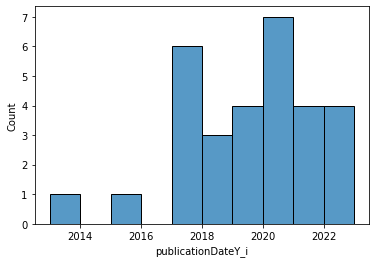

In [8]:
#NB: data is more complete in recent years, it is a known bias. 
response = requests.get("http://api.archives-ouvertes.fr/search/?q=cazabet&wt=csv&fl=docType_s,publicationDateY_i")
as_csv =pd.read_csv(io.StringIO(response.text),sep=",")

#using seaborn library for ploting
sns.histplot(as_csv["publicationDateY_i"],binwidth=1)

docType_s
ART        8
COMM      17
COUV       3
POSTER     1
THESE      1
Name: docType_s, dtype: int64


<Axes: ylabel='docType_s'>

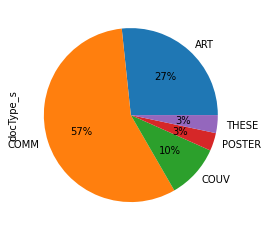

In [9]:
# Using pandas plotting tool. COMM =conferences, 
#ART =journals , COUV: book chapters, DOUV: direction of a publication
grouped=as_csv.groupby("docType_s")["docType_s"].count()
print(grouped)
grouped.plot.pie(autopct="%.0f%%")

# Larger datasets
**(A reusable function is provided, the code is here for reference)**

Answers from the API are limited to 10 000 elements. It is possible to obtain more elements, but this must be done by using a pagination method.

A simple way to proceed is to sort results according to a unique ID (`&sort=docid asc`), and then to return results from a certain line with `&start=num_ligne"`. 

Thus, with 35000 results, we can request the first 10 000 ones, then those from index 10000 to 20000, then from 20000 to 30000, and finally from 30000 to 40000.


In [13]:
def get_all_elements(request_core,page_size=1000):
    df_complet=pd.DataFrame()
    
    #en faisant la requête en json, on peut obtenir le nombre de réponses à récupérer
    nb_reponses=requests.get(request_core).json()["response"]["numFound"]
    print("Total number of elements : ",nb_reponses)

    #Cette boucle incrémente le curseur de début, par pas de 1000, jusqu'à atteindre le dernier élément
    for i in range(0,nb_reponses,page_size):
        #On récupére le résultat, en rajoutant des options à la requete de base
        response =requests.get(request_core+"&wt=csv&sort=docid asc&start="+str(i)+"&rows="+str(page_size))
        df_temp =pd.read_csv(io.StringIO(response.text),sep=",")

        #On ajoute les réponses les plus récentes à celles que l'on a déjà
        df_complet=pd.concat([df_complet,df_temp],ignore_index=True)
        print("Retrieved elements : ",len(df_complet))
    
    return df_complet #la fonction renvoie le tableau complet


## Request using a single line

In [14]:
#for instance, all articles with network and graph in title/abstract
request="http://api.archives-ouvertes.fr/search/?q=(network AND graph)"

#We call the function for this request
result = get_all_elements(request)

#We check that, at the end, we have the right elements
result

Total number of elements :  4744
Retrieved elements :  1000
Retrieved elements :  2000
Retrieved elements :  3000
Retrieved elements :  4000
Retrieved elements :  4744


,docid,halId_s,version_i,docType_s,citationFull_s,citationRef_s
0,1000025,hal-01000025,1,ART,"Steven S. Gazal, Jean-Jacques J.-J. Daudin, Stephane S. Robin. Accuracy of variational estimates...","<i>Journal of Statistical Computation and Simulation</i>, 2012, 82 (6), pp.849-862. <a target=""_..."
1,100008,inria-00100008,1,COMM,"Tarek Abbes, Alakesh Haloi, Michaël Rusinowitch. High Performance Intrusion Detection using Traf...",<i>International Conference on Advances in Intelligent Systems - Theory and Applications - AISTA...
2,100158,inria-00100158,1,COMM,"Claire François, Marianne Hoerlesberger, Shadi Al Shehabi, Xavier Polanco, Jean-Charles Lamirel....","<i>8th International Conference on Science and Technology Indicators - ST 2004</i>, 2004, Leiden..."
3,1001605,hal-01001605,1,ART,"Arnaud A. Dragicevic, Bernard B. Sinclair-Desgagné. Sustainable network dynamics. <i>Cahiers du ...","<i>Cahiers du LEF</i>, 2012, Documents de Travail. INRA Laboratoire d'Economie Forestière (LEF),..."
4,1001828,hal-01001828,1,ART,"Fabio Morbidi, Alain Kibangou. A Distributed Solution to the Network Reconstruction Problem. <i>...","<i>Systems and Control Letters</i>, 2014, 70, pp.85-91. <a target=""_blank"" href=""https://dx.doi...."
...,...,...,...,...,...,...
4739,998394,tel-00998394,1,THESE,Marina Sokol. Graph-based semi-supervised learning methods and quick detection of central nodes....,"Other [cs.OH]. Université Nice Sophia Antipolis, 2014. English. <a target=""_blank"" href=""https:/..."
4740,998529,hal-00998529,1,ART,"Pierre Fraigniaud, Cyril Gavoille, Adrian Kosowski, Emmanuelle Lebhar, Zvi Lotker. Universal Aug...","<i>Theoretical Computer Science</i>, 2009, 410 (21-23), pp.1970-1981. <a target=""_blank"" href=""h..."
4741,998811,hal-00998811,1,COMM,"Jinxian Lu, Christophe Dousson, Benoît Radier, Francine Krief. Towards an Autonomic Network Arch...","<i>4th International Conference on Autonomous Infrastructure, Management and Security (AIMS 2010..."
4742,998854,tel-00998854,1,HDR,Nicolas Nisse. Algorithmic complexity: Between Structure and Knowledge How Pursuit-evasion Games...,"Data Structures and Algorithms [cs.DS]. Université Nice Sophia Antipolis, 2014"


# Creation of a co-author network
**(A reusable function is provided, the code is here for reference)**

Let's imagine that we would like to study the co-author network (who works with whom) of Lyon's researchers working on *networks*, during the last 10 years. We can proceed in 4 steps :
1. Retrieving the information we are interested in
2. For every article with more than 1 author, count a link between them
3. Une networkx to create the network
4. Export it in a file in order to export it to Gephi (for instance)

In [15]:
def co_occurence_network(request,column,threshold=1):
    collab_list=[]
    node_list=[] #To make the network more insteresting, we also collect the number of articles by author:




    for collab in list(request[column]): #for every article
        nodes=str(collab).replace("\\,","_").split(",") #list of author names
        nodes=set(nodes)
        if len(nodes)<=5: #if not too many elements
            
            for node in nodes:#remember we have seen that node
                node_list.append(node)
                
            for node1,node2 in combinations(nodes,2): #for every pair of authors
                collab_list.append(frozenset((node1,node2))) #adding a collaboration
                #note the set (frozenset), imposing no order between elements: 
                #set((lab1,lab2))==set((lab2,lab1)) while [aut1,aut2]!=[aut2,aut1]
    
    #We count how many times each node appears:
    nodes=[]
    occurences=node_list
    for n,occ in dict(collections.Counter(occurences)).items(): #collections.Counter count occurences by item
        if occ>threshold: #we filter out singleton to keep important actors
            nodes.append((n,{"occurences":occ})) #we store the result in a format convenient for networkx
    
    #We count how many times each link appears:
    edges=[]
    occurences=collab_list
    for n,occ in dict(collections.Counter(occurences)).items(): #collections.Counter count occurences by item
        if occ>threshold: #we filter out singleton to keep important relations
            n1,n2=n
            edges.append((n1,n2,{"occurences":occ})) #we store the result in a format convenient for networkx
            
    #creating the graph to return
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    return g

## We can now use this function
Our request just need to ask for the column `authFullName_s`


In [16]:
request = "http://api.archives-ouvertes.fr/search/UNIV-LYON/?q=abstract_t:(network -neural)&fq=publicationDate_s:[2012 TO 2024]&fl=title_s,authFullName_s,abstr*"
co_aut = get_all_elements(request)


Total number of elements :  2500
Retrieved elements :  1000
Retrieved elements :  2000
Retrieved elements :  2500


In [17]:
g = co_occurence_network(co_aut,"authFullName_s")

### Visualisation and export
We can first check that we indeed obtained an network, using networkx built-in function

In [18]:
#removing nodes without edges to simplify
g.remove_nodes_from(list(nx.isolates(g)))

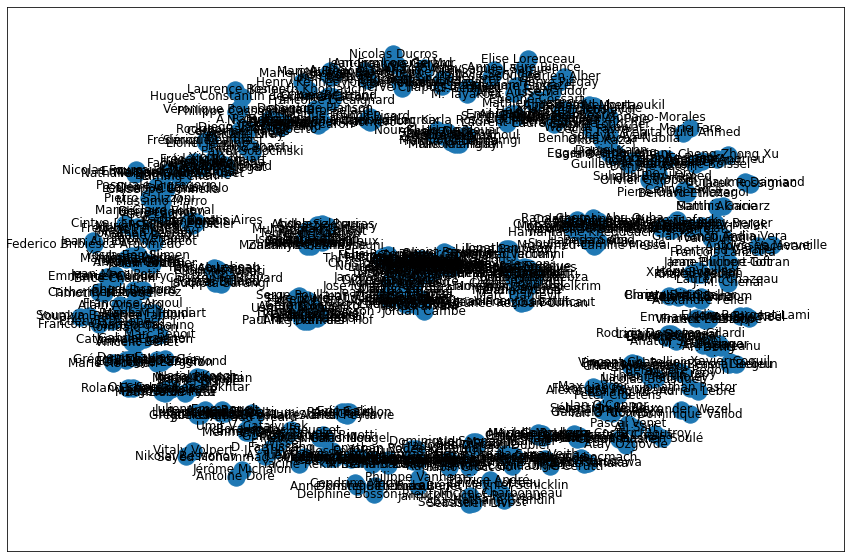

In [19]:
#Visualizing
plt.figure(1,figsize=(15,10)) 
pos=nx.fruchterman_reingold_layout(g)
nx.draw_networkx(g,pos=pos)

In [20]:
#Finally exporting to graphml
#Note that atttributes (number of occurences) of nodes and edges are accessible
nx.write_graphml(g,"cocitation.graphml") 

# Network of relations between labs
By using the same approach with labs instead of authors, we can create a network of collaboration between labs

Here the only differences are:
* In the request, not limiting to Lyon
* In the function, we impose the "institution" column to correspond to a laboratory (not university, etc.)
* We impose the lab to be located in France.

Check the code to see how this is done

In [21]:
def co_occurence_network_laboratory(request,column,threshold=1):
    collab_list=[]
    node_list=[]
    
    struct_names=list(request[column])
    struct_types=list(request["structType_s"]) # We also get types of structures
    struct_countries=list(request["structCountry_s"]) #and countries
    
    for i,collab in enumerate(struct_names):
        nodes_unfiltered=str(collab).replace("\\,","_").split(",") 
        
        #We split them the same way
        types=str(struct_types[i]).replace("\\,","_").split(",") 
        countries=str(struct_countries[i]).replace("\\,","_").split(",") 
        
        #We filter the structure (nodes) to keep only french laboratories
        nodes=set()
        try:
            for j,name in enumerate(nodes_unfiltered):
                if types[j]=="laboratory" and countries[j]=="fr":
                    nodes.add(name)
        except:#if there is a problem
            pass # ignore this item
        
        if len(nodes)>1:
            for node in nodes:
                node_list.append(node)

            if len(nodes)<=10: 
                for node1,node2 in combinations(nodes,2): 
                    collab_list.append(frozenset((node1,node2))) 

    nodes=[]
    occurences=node_list
    for n,occ in dict(collections.Counter(occurences)).items(): 
        if occ>threshold: 
            nodes.append((n,{"occurences":occ})) 
    
    edges=[]
    occurences=collab_list
    for n,occ in dict(collections.Counter(occurences)).items(): 
        if occ>threshold:
            n1,n2=n
            edges.append((n1,n2,{"occurences":occ}))
            
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    return g

In [22]:
request="http://api.archives-ouvertes.fr/search/?q=abstract_t:(network -neural) AND structCountry_s:fr&fq=publicationDate_s:[2012 TO 2024]&fl=structAcronym_s,structCountry_s,structAddress_s,structType_s,structName_s"
colab_lab = get_all_elements(request,5000)

Total number of elements :  41294
Retrieved elements :  5000
Retrieved elements :  10000
Retrieved elements :  15000
Retrieved elements :  20000
Retrieved elements :  25000
Retrieved elements :  30000
Retrieved elements :  35000
Retrieved elements :  40000
Retrieved elements :  41294


In [20]:
g = co_occurence_network_laboratory(colab_lab,"structName_s")

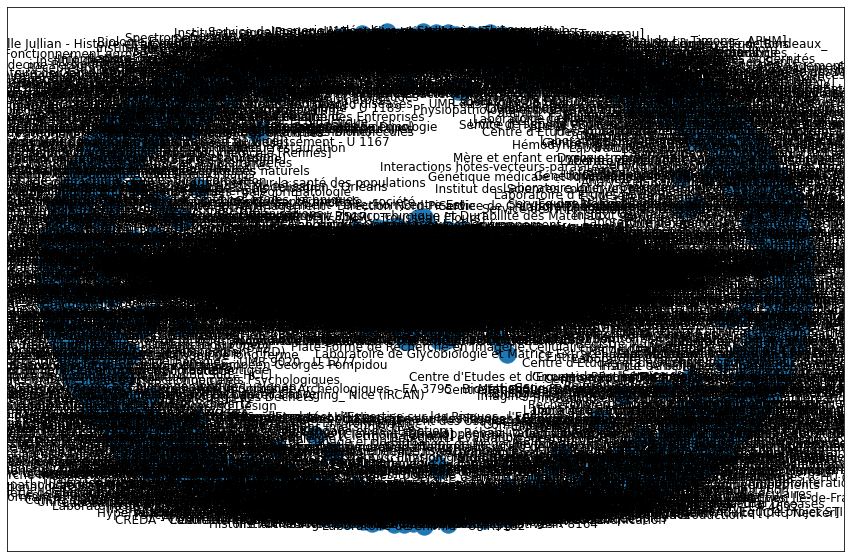

In [21]:
plt.figure(1,figsize=(15,10)) 
pos=nx.fruchterman_reingold_layout(g)
nx.draw_networkx(g,pos=pos)

## Bi-partite Network
In this part, we write a method allowing to generate bi-partite network between elements.
For instance, we can create networks with paper-author, paper-keywords, author-keywords, laboratory-keywords, etc. relationships. In all cases, elements are connected if they appear together in the same article

In [24]:
def bi_partite_network_generic(request,column1,column2,threshold_max_in_col=10,column1_attributes=[],column2_attributes=[]):
    authorship=[]
    node_list=[] 
    column1_attributes+=[column1]
    column2_attributes+=[column2]




    for index,row in request.iterrows(): #pour tous les articles
        #print(row)
        nodes1=str(row[column1]).replace("\\,","_").split(",") 
        nodes2=str(row[column2]).replace("\\,","_").split(",") 


        article_id=index
        if len(nodes1)<=threshold_max_in_col and len(nodes2)<=threshold_max_in_col:
            
            for i,node1 in enumerate(nodes1):
                for j,node2 in enumerate(nodes2):
                    node1ID=node1
                    node2ID=node2
                    if len(node1)>20:
                        hash_object = hashlib.sha1(node1.encode())
                        node1ID = hash_object.hexdigest()
                    if len(node2)>20:
                        hash_object = hashlib.sha1(node2.encode())
                        node2ID = hash_object.hexdigest()
                    authorship.append((node1ID,node2ID))
                    #node_list.append(node)
                
                    if not node2ID in node_list:
                        attributes={}
                        attributes["type"]="col2"
                        attributes["label"]=node2


                        node_list.append((node2ID,attributes))
                
                if not node1ID in node_list:
                    attributes={}
                    attributes["type"]="col1"
                    attributes["label"]=node1
                    node_list.append((node1ID,attributes))
    #En utilisant networkx, nous créons un objet graphe
    counts=dict(collections.Counter(authorship))
    counts = [[u,v,w] for (u,v),w in counts.items()]
    g = nx.Graph()
    g.add_nodes_from(node_list)
    g.add_weighted_edges_from(counts,"occurrences")
    return g

In [25]:
request = "http://api.archives-ouvertes.fr/search/UNIV-LYON/?q=abstract_t:(network -neural)&fq=publicationDate_s:[2020 TO 2022]&fl=title_s,authFullName_s,level0_domain_s"
bipartite = get_all_elements(request)

Total number of elements :  598
Retrieved elements :  598


In [26]:
g = bi_partite_network_generic(bipartite,"title_s","authFullName_s")

In [27]:
#we keep only the repeated values
k=2
to_remove = [(a,b) for a, b, attrs in g.edges(data=True) if attrs["occurrences"] <k]
g.remove_edges_from(to_remove)
g.remove_nodes_from(list(nx.isolates(g)))

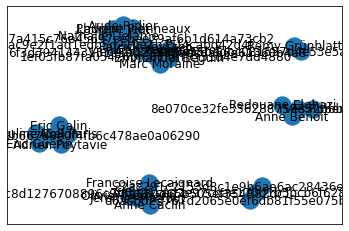

In [28]:
nx.draw_networkx(g)

## Useful functions
Other functions that can be useful

In [29]:
#Function allowing to create a new column in the dataframe,
#containing the most frequent element from another column. If several elements have the same nb of occurences
#the first is returned.

#Example of usage: link a unique country, lab, or cateogy to an article
def column_most_common(df,previous_name,new_name):
    def most_common(l):
        count = collections.Counter(l)
        most = count.most_common(1)[0][0]
        return most
    df[new_name]=df.apply(lambda row: most_common(str(row[previous_name]).split(",")), axis=1)

In [30]:
#Example:
column_most_common(bipartite,"level0_domain_s","main_domain")
